# **Classification of Luxury Bags Authentication**

## **1. Import Library**

In [ ]:
import os                                                  # Operating system interfaces
import tensorflow as tf                                    # TensorFlow deep learning framework
import json                                                # JSON encoder and decoder
import matplotlib.pyplot as plt                            # Plotting library
import matplotlib.image as mpimg                           # Image loading and manipulation library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model      # Sequential and Functional API for building models
from tensorflow.keras.optimizers import Adam               # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping       # Early stopping callback for model training
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19   # Pre-trained models for transfer learning

## **2. Preprocessing Data + Overview Data**

### Data Training

In [ ]:
# Load dataset
train_data = tf.keras.utils.image_dataset_from_directory( # Membaca dataset dari direktori
    'dataset_tas/train',      # Lokasi dataset untuk training
    labels='inferred',        # Menggunakan label yang sudah ada di direktori
    label_mode='categorical', # Menggunakan label sebagai kategori (one-hot encoding)
    image_size=(256, 256),    # Ukuran gambar diresize menjadi 256x256
    batch_size=32             # Ukuran batch
)

# Simpan nama kelas sebelum melakukan map
class_names = train_data.class_names
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# Normalize image data
# Membagi nilai pixel dengan 255 untuk menormalisasi nilai pixel menjadi rentang 0-1
# Mebantu model bekerja lebih baik
train_data = train_data.map(lambda x, y: (x / 255.0, y))

Found 160 files belonging to 2 classes.


### Data Testing

In [ ]:
# Load test dataset
test_data = tf.keras.utils.image_dataset_from_directory( # Membaca dataset dari direktori
    'dataset_tas/test',         # Lokasi dataset untuk testing
    labels='inferred',          # Menggunakan label yang sudah ada di direktori
    label_mode='categorical',   # Menggunakan label sebagai kategori (one-hot encoding)
    image_size=(256, 256),      # Ukuran gambar diresize menjadi 256x256
    batch_size=32               # Ukuran batch
)

# Normalize test data
# Membagi nilai pixel dengan 255 untuk menormalisasi nilai pixel menjadi rentang 0-1
# Mebantu model bekerja lebih baik
test_data = test_data.map(lambda x, y: (x / 255.0, y))

Found 8 files belonging to 2 classes.


### Overview Data

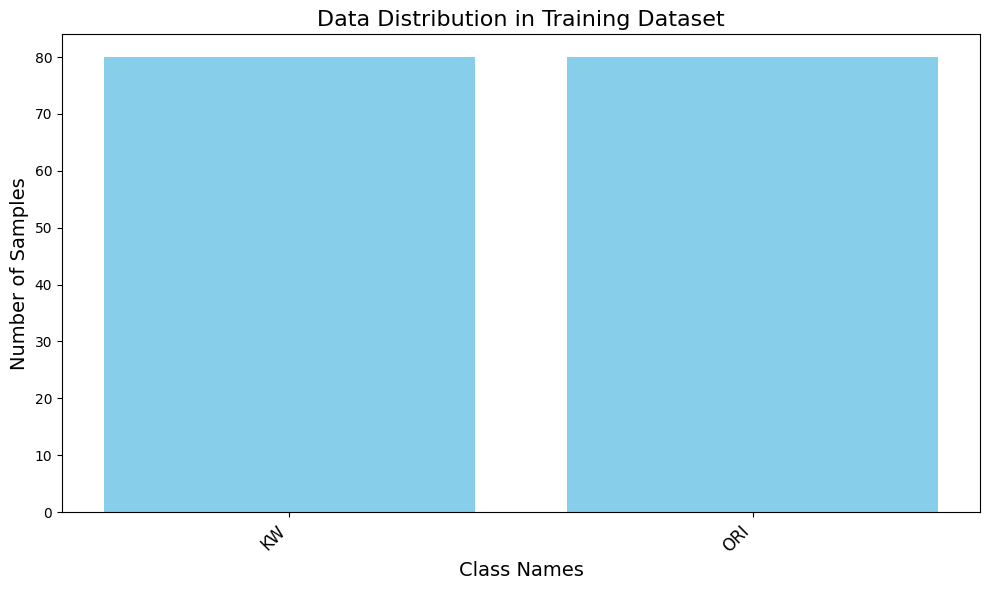

In [ ]:
import numpy as np
from collections import Counter

# Count samples per class
label_counts = Counter()
for _, labels in train_data:
    label_indices = np.argmax(labels.numpy(), axis=1)  # Convert one-hot to label indices
    label_counts.update(label_indices)

# Prepare data for plotting
labels = [class_names[i] for i in range(len(class_names))]
counts = [label_counts[i] for i in range(len(class_names))]

# Plot the data distribution
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class Names', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Data Distribution in Training Dataset', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Compute total classes and total samples (Data Training)
total_classes = len(class_names)
total_samples = sum(label_counts.values())

# Display the summary
print(f"Total Classes: {total_classes}")
print(f"Total Samples: {total_samples}")
print("Samples per Class:")
for class_idx, count in label_counts.items():
    print(f"{class_names[class_idx]}: {count}")

Total Classes: 2
Total Samples: 160
Samples per Class:
ORI: 80
KW: 80


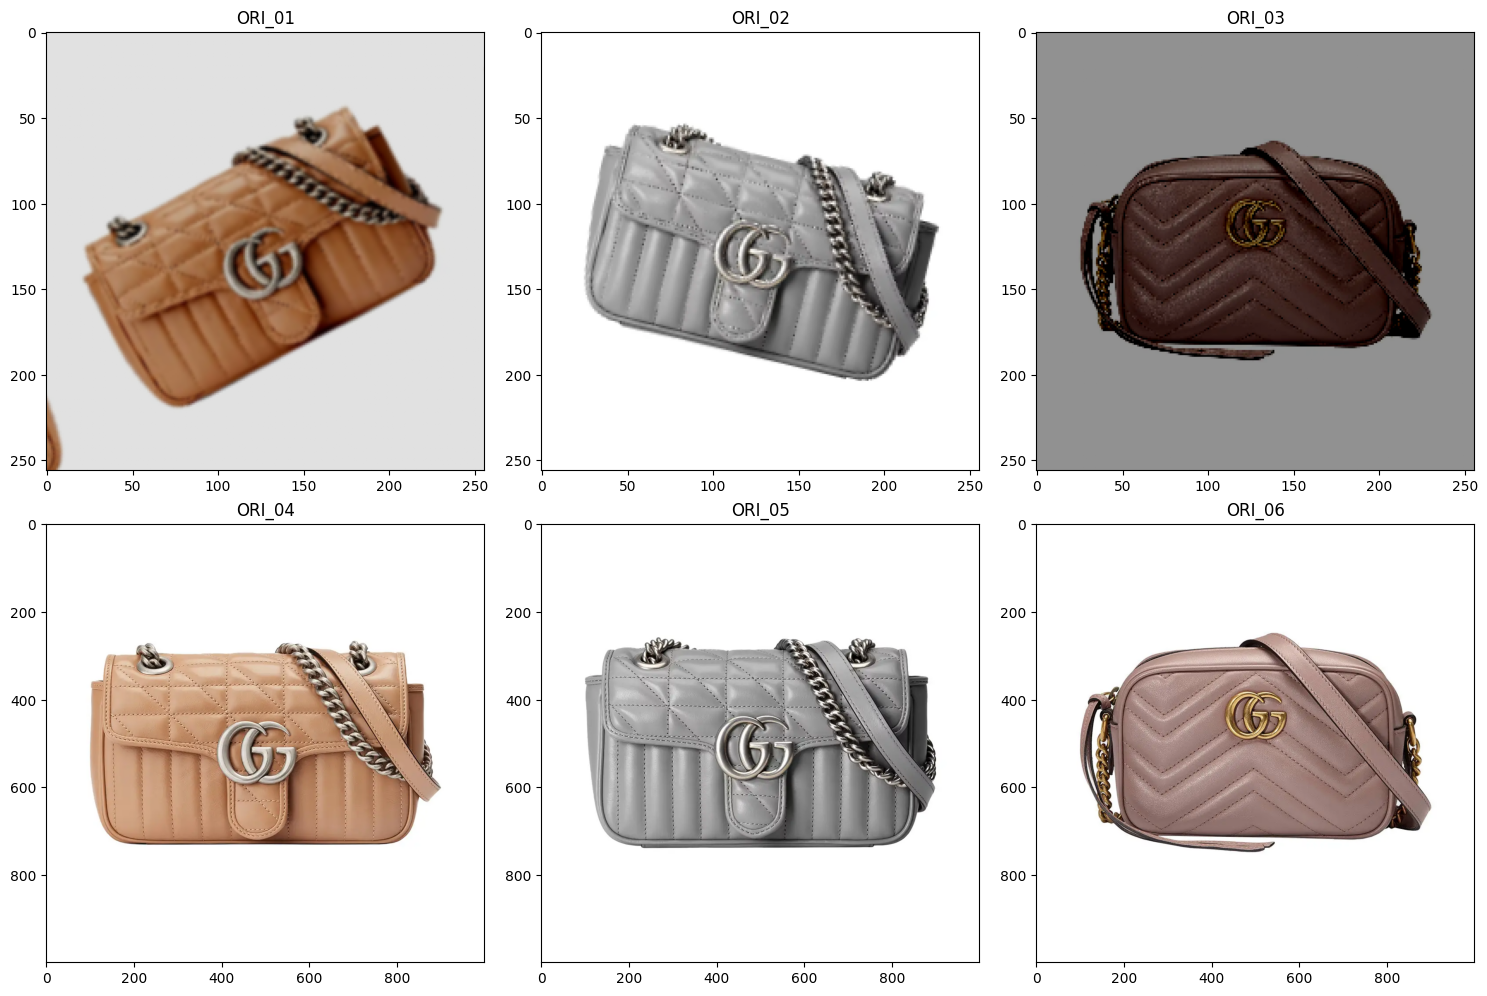

In [ ]:
# Path to the directory containing images
path = "dataset_tas/train/ORI"

# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis()
    ax.set_title(label)

plt.tight_layout()
plt.show()

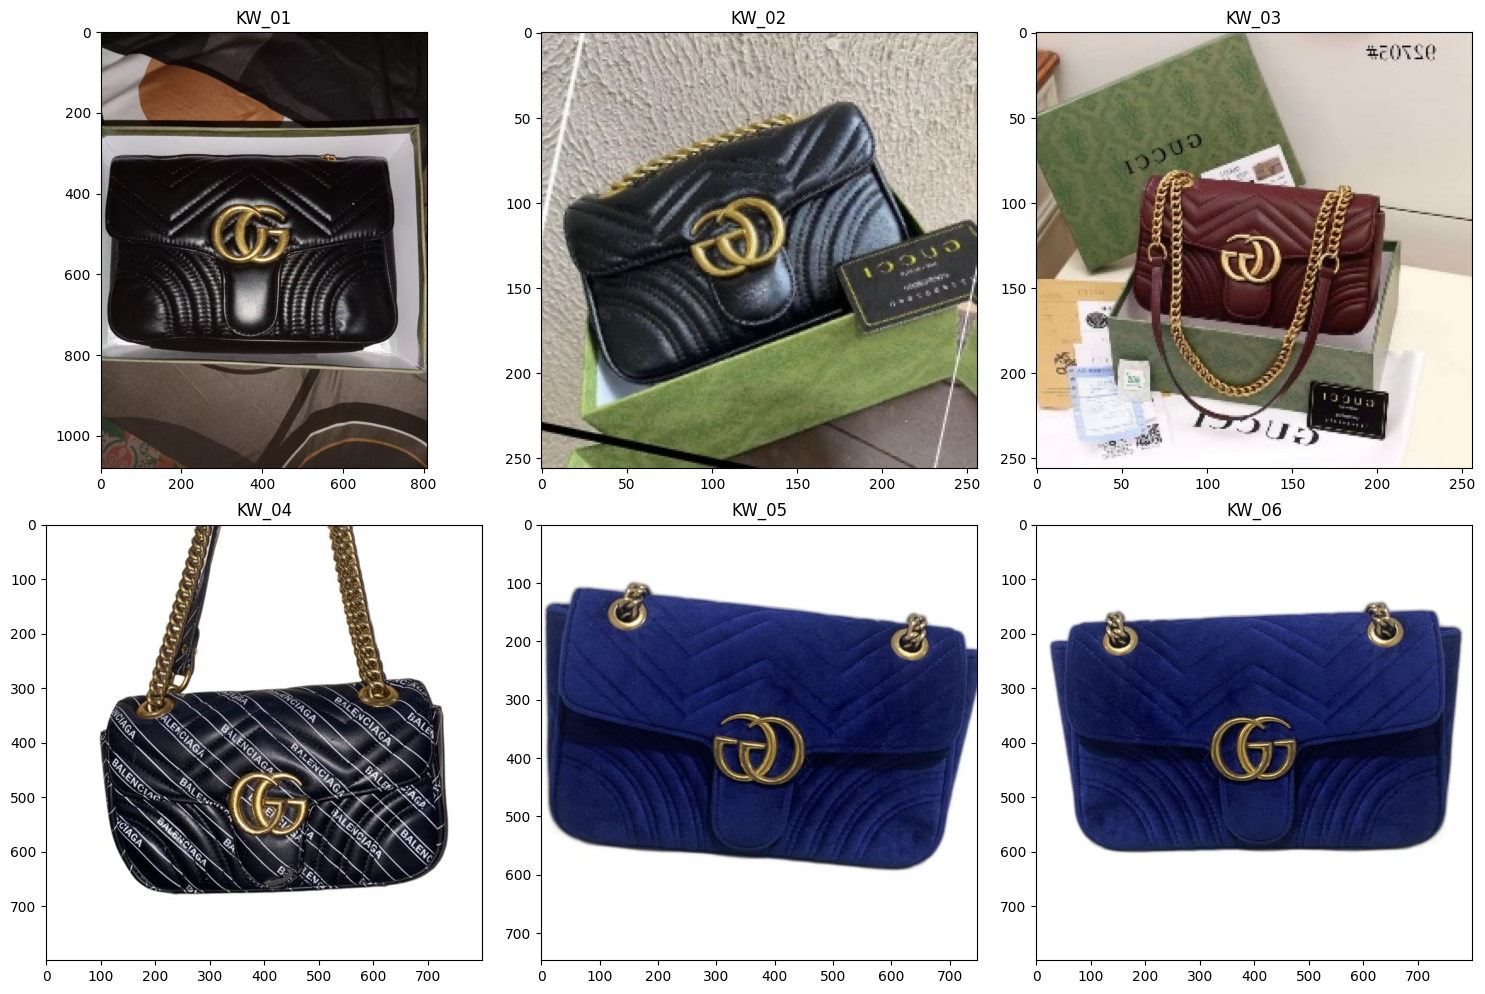

In [ ]:
# Path to the directory containing images
path = "dataset_tas/train/KW"

# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis()
    ax.set_title(label)

plt.tight_layout()
plt.show()

## **3. Modeling**

In [ ]:
# DenseNet121 sebagai model pre-trained
conv_base = DenseNet121(        # Model pre-trained dari Keras dengan bobot yang sudah dilatih pada dataset ImageNet
    weights='imagenet',
    include_top = False,        # Hanya menggunakan bagian convolutional, tanpa layer fully connected di atasnya
    input_shape=(256,256,3),    # Resize ke ukuran 256x256
    pooling='avg'               # Menggunakan average pooling untuk mereduksi output menjadi satu dimensi
)

conv_base.trainable = False     # Membekukan layer pretrained agar tidak dilatih ulang (hanya sebagai fitur ekstraktor)

# Mebangun model tambahanan (custom head)
model = Sequential()
model.add(conv_base)
model.add(BatchNormalization())          # Menormalkan output dari layer sebelumnya, mempercepat pelatihan dan meningkatkan stabilitas
model.add(Dense(256, activation='relu')) # Layer fully connected pertama dengan 256 neuron dan aktivasi ReLU untuk menangkap hubungan non-linear
model.add(Dropout(0.35))                 # Menghilangkan 35% neuron secara acak untuk mencegah overfitting
model.add(BatchNormalization())
model.add(Dense(120, activation='relu')) # Layer tambahan untuk mengolah lebih jauh fitur sebelum klasifikasi akhir
model.add(Dense(2, activation='softmax'))# Layer output dengan 2 neuron (jumlah kelas) dan aktivasi softmax untuk menghasilkan probabilitas kelas

# Kompilasi Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Hapus cache Keras sebelum pelatihan
tf.keras.backend.clear_session()

history = model.fit(
    train_data,
    epochs=25,
    callbacks=[EarlyStopping(patience=0)]
)


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4828 - loss: 0.9350
Epoch 2/25


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6452 - loss: 0.6537
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7646 - loss: 0.5015
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8689 - loss: 0.3462
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9347 - loss: 0.2146
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9682 - loss: 0.1595
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9510 - loss: 0.1756
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9819 - loss: 0.1038
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9966 - loss: 0.0948
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 0.0747
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 0.0629
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9966 - loss: 0.0534
Epoch 13/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9871 - loss: 0.0623
Epoch 14/25
5/5 ━━━━━━━

In [ ]:
# Menyimpan model ke format TensorFlow SavedModel
# model.save('model_densenet')  # Akan membuat folder bernama 'model_densenet'

# Atau simpan dalam format HDF5
model.save('model_densenet.h5')  # Menyimpan sebagai file tunggal

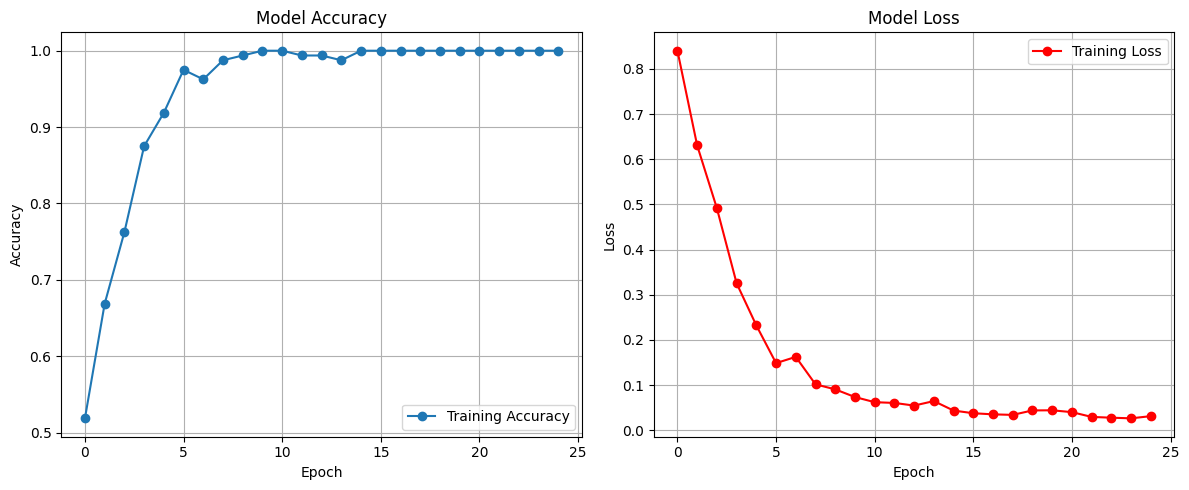

In [ ]:
import matplotlib.pyplot as plt

# Ekstrak informasi akurasi dan loss dari history
accuracy = history.history['accuracy']
loss = history.history['loss']

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Buat subplot untuk akurasi
plt.plot(accuracy, label='Training Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)  # Buat subplot untuk loss
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Tampilkan kedua plot
plt.tight_layout()
plt.show()

## **4. Evaluation + Testing**

In [ ]:
from sklearn.metrics import classification_report

# Evaluate on test data
y_true = []  # Label sebenarnya
y_pred = []  # Prediksi model

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy().argmax(axis=1))  # Konversi ke indeks label
    y_pred.extend(predictions.argmax(axis=1))  # Pilih kelas dengan probabilitas tertinggi

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
              precision    recall  f1-score   support

          KW       0.83      1.00      0.91         5
         ORI       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8



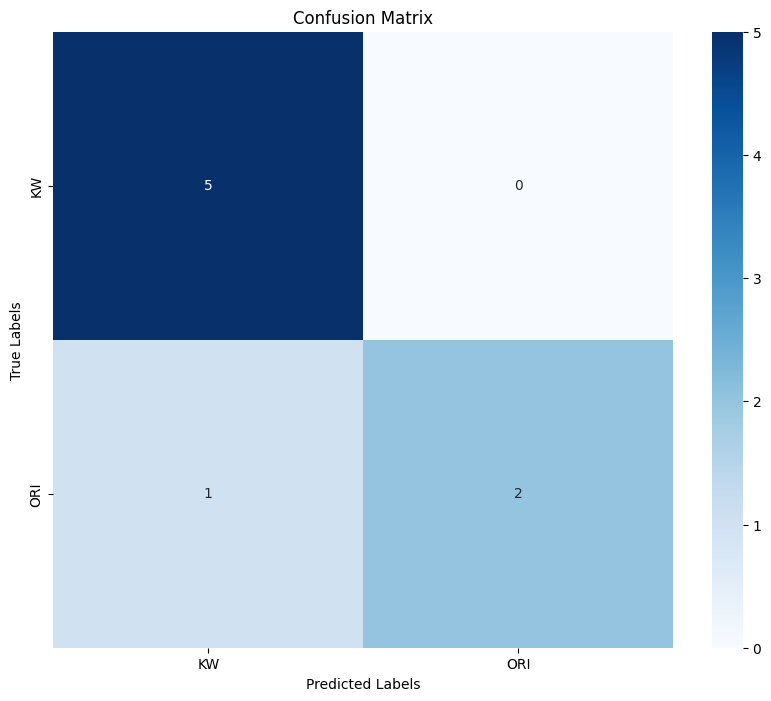

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fungsi untuk menguji model dengan gambar baru
def test_single_image(model, image_path, class_names):
    # Load dan preprocess gambar
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img) / 255.0  # Normalisasi gambar
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Prediksi dengan model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]

    # Tampilkan hasil prediksi
    print(f"Prediksi: {class_names[predicted_class]} dengan kepercayaan {confidence:.2f}")

### Testing (Uji Coba Data Baru)

Test ORI

In [ ]:
# Uji gambar baru
image_path = 'template/test_asli.png'  # Path ke gambar baru
test_single_image(model, image_path, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Prediksi: ORI dengan kepercayaan 0.76


In [ ]:
# Uji gambar baru
image_path = 'template/test_asli2.jpg'  # Path ke gambar baru
test_single_image(model, image_path, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Prediksi: ORI dengan kepercayaan 0.64


Test KW

In [ ]:
# Uji gambar baru
image_path = 'template/test_kw.png'  # Path ke gambar baru
test_single_image(model, image_path, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Prediksi: KW dengan kepercayaan 0.76


In [ ]:
# Uji gambar baru
image_path = 'template/test_kw2.jpg'  # Path ke gambar baru
test_single_image(model, image_path, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Prediksi: KW dengan kepercayaan 1.00


In [ ]:
# Uji gambar baru
image_path = 'template/test_kw3.jpg'  # Path ke gambar baru
test_single_image(model, image_path, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Prediksi: KW dengan kepercayaan 0.99
